In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.utils
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import os
from sklearn.metrics import f1_score

In [84]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [85]:
class SiameseNetworkDataset(Dataset):
    # load in true and false dataset
    # define anchor images
    def __init__(self,imageFolderDataset,false_dataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.false_dataset = false_dataset
        self.transform = transform

        folder = r"D:\PycharmProjects\AISS\siamese\dataset_true"
        self.reference_imgs0 = self.prepare_imgs(os.path.join(folder,"0", "82_14491.jpg"))


        self.reference_imgs1 = self.prepare_imgs(os.path.join(folder,"1", "42_14314.jpg"))


        self.reference_imgs2 = self.prepare_imgs(os.path.join(folder,"2", "02_3176.jpg"))


        self.reference_imgs3 = self.prepare_imgs(os.path.join(folder,"3", "310_18578.jpg"))

    def prepare_imgs(self, p):
        img = PIL.Image.open(p)

        width, height = img.size
        if width > height:
            img = img.transpose(Image.TRANSPOSE)
        transform = transforms.Compose([transforms.Resize((150, 50)),transforms.ToTensor()])
        img = transform(img)
        return img

    def __getitem__(self,index):
        # iterate over all images instead of choosing randomly
        # since we have 2 datasets, we have to design a custom logic to iterate over both
        if index > len(self.imageFolderDataset) -1:
            same = 0
            index = index - len(self.imageFolderDataset)
            img0_tuple = self.false_dataset[index]
        else:
            same = 1
            img0_tuple = self.imageFolderDataset[index]

        img0 = img0_tuple[0].convert('RGB')
        width, height = img0.size
        if width > height:
            img0 = img0.transpose(Image.TRANSPOSE)
        if self.transform is not None:
            img0 = self.transform(img0)
        class_ = img0_tuple[1]
        if random.randint(0,4) <3 and same==0:
            actual_class = class_
            while class_ == actual_class:
                class_ = random.randint(0,3)
            same= 0
        if class_ == 0:
            img1 = self.reference_imgs0
        if class_ == 1:
            img1 = self.reference_imgs1

        if class_ == 2:
            img1 = self.reference_imgs2

        if class_ == 3:
            img1 = self.reference_imgs3

        return img0,img1,  torch.from_numpy(np.array([same], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset) + len(self.false_dataset)

In [87]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root=r"D:\PycharmProjects\AISS\siamese\dataset_true")
false_dataset = datasets.ImageFolder(root=r"D:\PycharmProjects\AISS\siamese\dataset_false")

folder_dataset_test = datasets.ImageFolder(root=r"D:\PycharmProjects\AISS\siamese\dataset_true_val")
false_dataset_test = datasets.ImageFolder(root=r"D:\PycharmProjects\AISS\siamese\dataset_false_val")

# Augment + Resize the images and transform to tensors
transformation = transforms.Compose([
                                    transforms.Resize((150, 50)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                     transforms.ToTensor()

                                    ])

transformation_test = transforms.Compose([
                                    transforms.Resize((150, 50)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                     transforms.ToTensor()
                                    ])

# Initialize the dataset
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,false_dataset=false_dataset,
                                        transform=transformation)

siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,false_dataset=false_dataset_test,
                                        transform=transformation_test)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12336\2710478066.py:24: DeprecationWarning: TRANSPOSE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.TRANSPOSE instead.
  img = img.transpose(Image.TRANSPOSE)


C:\Users\Admin\AppData\Local\Temp\ipykernel_12336\2710478066.py:50: DeprecationWarning: TRANSPOSE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.TRANSPOSE instead.
  img1 = img1.transpose(Image.TRANSPOSE)


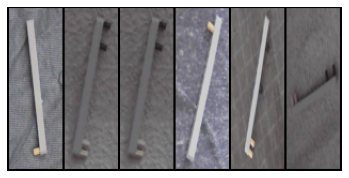

[0. 0. 1.]


In [88]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=3)
# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [89]:
# create the dataloaders
trainloader = DataLoader(siamese_dataset,
                        batch_size=16, shuffle=True)

testloader = DataLoader(siamese_dataset_test,
                        batch_size=16)

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models

class SiameseNetwork(nn.Module):
    def __init__(self, backbone="resnet18"):
        '''
        Creates a siamese network with a network from torchvision.models as backbone.
            Parameters:
                    backbone (str): Options of the backbone networks can be found at https://pytorch.org/vision/stable/models.html
        '''

        super().__init__()

        if backbone not in models.__dict__:
            raise Exception("No model named {} exists in torchvision.models.".format(backbone))

        # Create a backbone network from the pretrained models provided in torchvision.models
        self.backbone = models.__dict__[backbone](pretrained=True, progress=False, )
        for j, child in enumerate(self.backbone.children()):
            if j < 5:
                for param in child.parameters():
                    param.requires_grad = False

        self.backbone.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))
        # Get the number of features that are outputted by the last layer of backbone network.
        out_features = list(self.backbone.modules())[-1].out_features

        # Create a cls head for binary crosentropy
        # we experimented with different layer sizes and number of layers
        self.cls_head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2000, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, img1, img2):
        '''
        Returns the similarity value between two images.
            Parameters:
                    img1 (torch.Tensor): shape=[b, 3, 224, 224]
                    img2 (torch.Tensor): shape=[b, 3, 224, 224]
            where b = batch size
            Returns:
                    output (torch.Tensor): shape=[b, 1], Similarity of each pair of images
        '''

        # Pass the both images through the backbone network to get their seperate feature vectors
        feat1 = self.backbone(img1)
        feat2 = self.backbone(img2)

        # concat features instead of multiplying them pixelwise
        combined_features = torch.cat((feat1, feat2), 1)
        # Pass the combined feature vector through classification head to get similarity value in the range of 0 to 1.
        output = self.cls_head(combined_features)
        return output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork()

model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.BCELoss()



for epoch in range(300):
    print("[{} / {}]".format(epoch, 300))
    model.train()

    losses = []
    correct = 0
    total = 0
    preds_tr = []
    gt_tr = []
    # Training Loop Start
    model.train()
    for img1, img2, y in trainloader:
        optimizer.zero_grad()
        img1, img2, y = map(lambda x: x.to(device), [img1, img2, y])
        prob = model(img1, img2)
        loss = criterion(prob, y)


        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        flattened_list = [item for sublist in prob.tolist() for item in (sublist if isinstance(sublist, list) else [sublist])]
        flatt = [0 if i < 0.5 else 1 for i in flattened_list]
        preds_tr.extend(flatt)
        flattened_list = [item for sublist in y.tolist() for item in (sublist if isinstance(sublist, list) else [sublist])]
        gt_tr.extend(flattened_list)


    print("\tTraining: Loss={:.2f}\t ".format(np.mean(losses)))
    print(classification_report(gt_tr, preds_tr))
    # Training Loop End
    # start evaluation
    model.eval()

    correct = 0
    total = 0
    preds = []
    gt = []
    all_loss = []

    for img1, img2, y in testloader:

        img1, img2, y = map(lambda x: x.to(device), [img1, img2, y])
        prob = model(img1, img2)
        all_loss.append(criterion(prob, y).item())
        flattened_list = [item for sublist in prob.tolist() for item in (sublist if isinstance(sublist, list) else [sublist])]
        flatt = [0 if i < 0.5 else 1 for i in flattened_list]
        preds.extend(flatt)
        flattened_list = [item for sublist in y.tolist() for item in (sublist if isinstance(sublist, list) else [sublist])]
        gt.extend(flattened_list)

    l = np.mean(all_loss)
    print(f"val loss: {l}")
    print(classification_report(gt, preds))
    # Evaluation Loop Start
    f = f1_score(gt, preds, average='macro')



    # Save model based on the frequency defined by "args.save_after"
    if (epoch + 1) % 1 == 0:
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "backbone": "resnet-18",
                "optimizer_state_dict": optimizer.state_dict()
            },
            os.path.join("siamese","models_new", "epoch_{}_{}.pth".format(epoch + 1, f))
        )

In [ ]:
# load in saved model
model = SiameseNetwork()
model.load_state_dict(torch.load("siamese/models/epoch_35_0.8938460690362686.pth")["model_state_dict"])
model.cuda()

In [ ]:
# predict with anchor images
model.eval()
img2 = PIL.Image.open(r"D:\PycharmProjects\AISS\siamese\dataset_true\1\10_2830.jpg")
img1 = PIL.Image.open(r"D:\PycharmProjects\AISS_Seminar\testbild.jpg")

width, height = img1.size
if width > height:
    img1 = img1.transpose(Image.TRANSPOSE)
width, height = img2.size
if width > height:
    img2 = img2.transpose(Image.TRANSPOSE)
transform = transforms.Compose([transforms.Resize((150, 50)),transforms.ToTensor()])
img1 = transform(img1).cuda()
img2 = transform(img2).cuda()
img1 = img1[None, :]
img2 = img2[None, :]
outputs = model(img1, img2)
print(outputs.item())